# Bayesian Experimental Design

This demo shows how to use the GPUncertaintyOptimizer class to efficiently obtain new samples that will decrease the predictive variance of a GP model.

As a test case, we use the GaussianProcessRegressor class to regress the efficiency of three-jet events with MET < 50 GeV.

The following nuisance parameters are considered:
- $\nu_{J1}$: Jet energy scale of the leading jet, $J_1$.
- $\nu_{J23}$: Jet energy scale of the two softer jets, $J_2$ and $J_3$.

In [1]:
# Imports
import gpder
from gpder.gaussian_process import GaussianProcessRegressor
from gpder.gaussian_process.kernels import RegularKernel, DerivativeKernel
from gpder import GPUncertaintyOptimizer

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle, Arrow, FancyArrow
%matplotlib inline  

from multiprocessing import Pool, cpu_count

In [2]:
from utils import download_dataset, load_dataset

# Downloading the dataset from zenodo. 
# By default, the h5df file is saved in the current directory.
download_dataset()
threeM = load_dataset()

# The dataset consists of 30000 events, each with three jets. 
# For each jet, the three-momenta (pT, eta, phi) are saved in descending pT-order.
print("Shape of the dataset:", threeM.shape)

Shape of the dataset: (30000, 3, 3)


Title: Estimation of Unfactorizable Systematic Uncertainties
Keywords: 
Publication date: 2024-04-14
DOI: 10.5281/zenodo.10971439
Total size: 1.0 MB

Link: https://zenodo.org/api/records/10971439/files/three_jets_30k.h5/content   size: 1.0 MB
three_jets_30k.h5 is already downloaded correctly.
All files have been downloaded.


In [3]:
# Function that calculates the efficiency with respect to the two nuisance
# See hep_functions.py for more details
from hep_functions import efficiency
def efficiency_events(X, threeM=threeM):
    # Simplifying the input
    return efficiency(X, threeM)

# And the function that calculates the gradient of the efficiency
# To improve numerical stability, we smooth out the gradients by setting the
# parameter a=1/10
from hep_functions import der_efficiency
def der_efficiency_events_sigmoid10(X, threeM=threeM):
    # Simplifying the input
    return der_efficiency(X, threeM, a=1/10)


## Regular GP regression

The regular GP used in the regular_GP_regression notebook has five training samples. Here, we use the BED strategy to select 10 new training samples. 

In [4]:
# -- Test dataset ---------------------------------------------------------- #
res_test = 25
X_lower, X_upper = 0.5, 1.5
lin = np.linspace(X_lower, X_upper, res_test)
nu_J1_test, nu_J23_test = np.meshgrid(lin, lin)
X_test = np.array([nu_J1_test.flatten(), nu_J23_test.flatten()]).T
y_test = Pool(cpu_count()).map(efficiency_events, X_test)
y_test = np.array(y_test)
# -------------------------------------------------------------------------- #

# -- Trainning dataset ----------------------------------------------------- #
nu_J1_train = [0.75, 1.0, 1.0, 1.0, 1.25]
nu_J23_train = [1.0, 0.75, 1.0, 1.25, 1.0]
X_train = np.array([nu_J1_train, nu_J23_train]).T
y_train = Pool(cpu_count()).map(efficiency_events, X_train)
y_train = np.array(y_train)
# -------------------------------------------------------------------------- #

# -- Utility input --------------------------------------------------------- #
# The utility input is used to evaluate the net predictive variance of the
# GP model at every BED iteration.
lin = np.linspace(X_lower, X_upper, 10)
nuJ1_util, nuJ23_util = np.meshgrid(lin, lin)
X_util = np.vstack((nuJ1_util.flatten(), nuJ23_util.flatten())).T
# -------------------------------------------------------------------------- #

In [5]:
# -- Fitting the GP model and hyperparameter optimization ------------------ #
kernel = RegularKernel(amplitude=0.1, length_scale=0.25, noise_level=1e-3)
# Set optimizer=None to skip optimization
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
gp_reg.fit(X_train, y_train)
print(gp_reg.kernel)
# -------------------------------------------------------------------------- #

# -- BED ------------------------------------------------------------------- #
BED_reg = GPUncertaintyOptimizer(
    gp_model=gp_reg,
    bounds={"nu_J1": (X_lower, X_upper), "nu_J23": (X_lower, X_upper)},
    function=efficiency_events,
    random_state=42,
    verbose=True,
)
gp_reg = BED_reg.minimize_variance(
    X_util=X_util, n_iters=10, n_restarts_optimizer=10
)
# -------------------------------------------------------------------------- #

0.1**2 * RBF(length_scale=0.25) + WhiteKernel(noise_level=0.001)
| Iter |   nu_J1    |   nu_J23   |   Target   |
-----------------------------------------------
|  0   |    0.75    |    1.00    |    0.13    |
|  0   |    1.00    |    0.75    |    0.52    |
|  0   |    1.00    |    1.00    |    1.00    |
|  0   |    1.00    |    1.25    |    0.39    |
|  0   |    1.25    |    1.00    |    0.81    |
|  1   |    1.37    |    1.37    |    1.08    |
|  2   |    0.63    |    0.63    |    0.48    |
|  3   |    1.38    |    0.62    |    0.17    |
|  4   |    0.62    |    1.38    |    0.00    |
|  5   |    1.00    |    1.45    |    0.04    |
|  6   |    1.45    |    0.99    |    0.35    |
|  7   |    0.53    |    0.99    |    0.00    |
|  8   |    1.00    |    0.53    |    0.29    |
|  9   |    1.39    |    1.19    |    1.03    |
|  10  |    1.19    |    1.37    |    0.76    |


## Derivative GP regression

Likewise, here we use the BED strategy to select 10 new training samples for the derivative GP model from the derivative_GP_regression notebook. 

In [6]:
# -- Test dataset ---------------------------------------------------------- #
dy_test = Pool(cpu_count()).map(der_efficiency_events_sigmoid10, X_test)
dy_test = np.array(dy_test)
# -------------------------------------------------------------------------- #

# -- Trainning dataset ----------------------------------------------------- #
dy_train = Pool(cpu_count()).map(der_efficiency_events_sigmoid10, X_train)
dy_train = np.array(dy_train)
# -------------------------------------------------------------------------- #

In [8]:
# -- Fitting the GP model and hyperparameter optimization ------------------ #
kernel = DerivativeKernel(
    amplitude=0.1, length_scale=0.25, noise_level=1e-3, noise_level_der=1e-1
)
# Set optimizer=None to skip optimization
gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
gp_der.fit(X_train, y_train, X_train, dy_train)
print(gp_der.kernel)
# -------------------------------------------------------------------------- #

# -- BED ------------------------------------------------------------------- #
BED_der = GPUncertaintyOptimizer(
    gp_model=gp_der,
    bounds={"nu_J1": (X_lower, X_upper), "nu_J23": (X_lower, X_upper)},
    function=efficiency_events,
    der_function=der_efficiency_events_sigmoid10,
    random_state=42,
    verbose=True,
)
gp_der = BED_der.minimize_variance(
    X_util=X_util, n_iters=10, n_restarts_optimizer=10
)
# -------------------------------------------------------------------------- #

0.1**2 * DerivativeRBF(length_scale=0.25) + WhiteKernel(noise_level=0.001) + WhiteKernel_der(noise_level=0.1)
| Iter |   nu_J1    |   nu_J23   |   Target   |
-----------------------------------------------
|  0   |    0.75    |    1.00    |    0.13    |
|  0   |    1.00    |    0.75    |    0.52    |
|  0   |    1.00    |    1.00    |    1.00    |
|  0   |    1.00    |    1.25    |    0.39    |
|  0   |    1.25    |    1.00    |    0.81    |
|  1   |    1.40    |    0.60    |    0.18    |
|  2   |    0.60    |    0.60    |    0.42    |
|  3   |    1.40    |    1.40    |    1.09    |
|  4   |    0.60    |    1.40    |    0.00    |
|  5   |    1.00    |    1.50    |    0.02    |
|  6   |    1.00    |    0.50    |    0.31    |
|  7   |    0.50    |    1.00    |    0.00    |
|  8   |    1.50    |    1.00    |    0.33    |
|  9   |    1.49    |    0.54    |    0.43    |
|  10  |    0.75    |    1.44    |    0.00    |


## Comparison

Here, we compare the results of the regular vs derivative GP models after
every iteration of the BED strategy.

In [9]:
from utils import plot_regression

----- Regular GP Regression -----

Evaluation 
MSE:  0.015629145233436604
Total variance:  0.35944569660865827


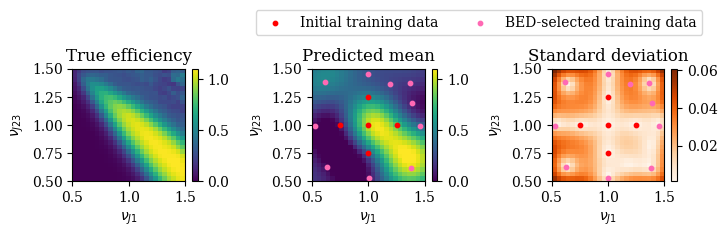

In [10]:
y_pred_mean, y_pred_std = gp_reg.predict(X_test, return_std=True)

print(("----- Regular GP Regression -----"))
print("\nEvaluation ")
mse = np.sum((y_test - y_pred_mean.ravel()) ** 2) / len(y_test)
print("MSE: ", mse)
print("Total variance: ", np.sum(y_pred_std**2))

plot_regression(gp_reg, X_test, y_test)


----- Derivative GP Regression -----

Evaluation 
MSE:  0.0069969529244656515
Total variance:  0.04552495870550442


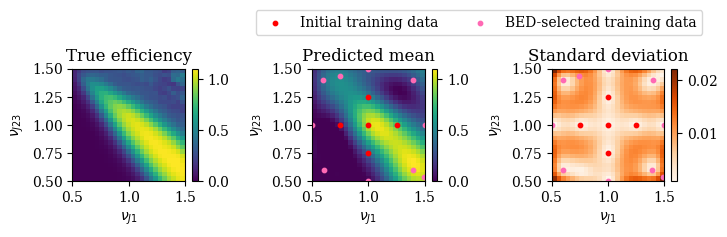

In [11]:
y_pred_mean, y_pred_std = gp_der.predict(X_test, return_std=True)

print(("----- Derivative GP Regression -----"))
print("\nEvaluation ")
mse = np.sum((y_test - y_pred_mean.ravel()) ** 2) / len(y_test)
print("MSE: ", mse)
print("Total variance: ", np.sum(y_pred_std**2))

plot_regression(gp_der, X_test, y_test)


The lower MSE and standard deviation values clearly reflect the advantage of including derivative observations in the GP regression model.